## The dataset

Each row in the file contains a daily record of the price of the S&P500 Index from `1950` to `2015`. The dataset is stored in `sphist.csv`.
 
The columns of the dataset are:

* Date -- The date of the record.
* Open -- The opening price of the day (when trading starts).
* High -- The highest trade price during the day.
* Low -- The lowest trade price during the day.
* Close -- The closing price for the day (when trading is finished).
* Volume -- The number of shares traded.
* Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.

You'll train the model with data from `1950-2012`, and try to make predictions from `2013-2015`

## Reading in the data

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [131]:
data = pd.read_csv('sphist.csv')

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


In [133]:
data['Date'] = pd.to_datetime(data['Date'])

In [134]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [135]:
data.sort_values(by='Date', ignore_index=1, inplace=True)

stock = data.copy()

## Generating indicators

Here are some indicators that are interesting to generate for each row:

* The average price from the past 5 days.
* The average price for the past 30 days.
* The average price for the past 365 days.
* The ratio between the average price for the past 5 days, and the average price for the past 365 days.
* The standard deviation of the price over the past 5 days.
* The standard deviation of the price over the past 365 days.
* The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

In [136]:
day_5 = []
day_30 = []
day_365 = []
for index, row in stock.iterrows():
    if index < 5:
        day_5.append(np.nan)
    else:
        day_5.append(stock.iloc[index-5:index, 4].mean())
    if index < 30:
        day_30.append(np.nan)
    else:
        day_30.append(stock.iloc[index-30:index, 4].mean())
    if index < 365:
        day_365.append(np.nan)
    else:
        day_365.append(stock.iloc[index-365:index, 4].mean())

In [137]:
stock['day_5'] = day_5
stock['day_30'] = day_30
stock['day_365'] = day_365

In [138]:
stock.day_365.isnull().sum()

365

In [139]:
stock

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343


## Splitting up the data

In [140]:
stock = stock[stock["Date"] > datetime(year=1951, month=1, day=2)]

In [141]:
stock.dropna(inplace=True)

c:\users\test\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
stock

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1.100000e+06,22.020000,21.800000,21.703333,19.447726
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1.120000e+06,21.910000,21.900000,21.683000,19.462411
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1.100000e+06,21.780001,21.972000,21.659667,19.476274
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1.340000e+06,21.549999,21.960000,21.631000,19.489562
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2.440000e+06,21.290001,21.862000,21.599000,19.502082
...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343


In [143]:
ressample = stock.copy()

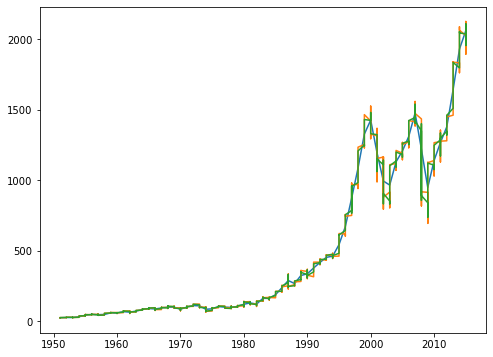

In [144]:
temp = ressample.set_index('Date').resample('AS').mean()
temp2 = ressample.set_index('Date').resample('5D').mean()
temp3 = ressample.set_index('Date').resample('30D').mean()
fig = plt.figure(figsize=(8,6))
plt.plot(temp.index.year, temp['Close'])
plt.plot(temp2.index.year, temp2['Close'])
plt.plot(temp3.index.year, temp3['Close'])
plt.show()

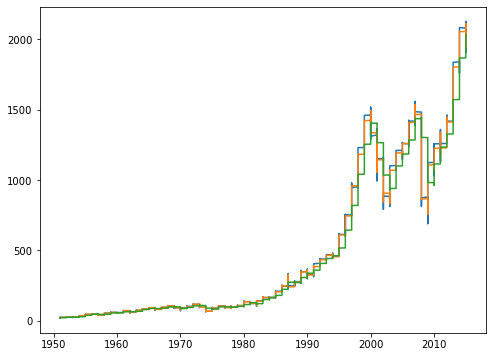

In [145]:
fig = plt.figure(figsize=(8,6))
plt.plot(stock['Date'].dt.year, stock['day_5'])
plt.plot(stock['Date'].dt.year, stock['day_30'])
plt.plot(stock['Date'].dt.year, stock['day_365'])
plt.show()

In [146]:
train = stock[stock['Date'] < datetime(2013,1,1)]

test = stock[stock['Date'] >= datetime(2013,1,1)]

In [147]:
train

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1.100000e+06,22.020000,21.800000,21.703333,19.447726
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1.120000e+06,21.910000,21.900000,21.683000,19.462411
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1.100000e+06,21.780001,21.972000,21.659667,19.476274
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1.340000e+06,21.549999,21.960000,21.631000,19.489562
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2.440000e+06,21.290001,21.862000,21.599000,19.502082
...,...,...,...,...,...,...,...,...,...,...
15846,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,1437.360010,1405.926001,1326.114028
15847,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,1436.620019,1407.486336,1326.412494
15848,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1408.813000,1326.716494
15849,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,1427.685986,1410.265332,1326.995836


In [148]:
test

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
15851,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055
15852,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247
15853,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877
15854,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617
15855,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603
...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343


## Making predictions

In [149]:
x_train = train[['day_5', 'day_30', 'day_365']]
y_train = train['Close']

x_test = test[['day_5', 'day_30', 'day_365']]
y_test = test['Close']

In [150]:
lr = LinearRegression()

lr.fit(x_train, y_train)

preds = lr.predict(x_test)

mean_absolute_error(y_test, preds)

16.1424396435549

## Improving error

Here are some ideas that might be helpful:

* The average volume over the past five days.
* The average volume over the past year.
* The ratio between the average volume for the past five days, and the average volume for the past year.
* The standard deviation of the average volume over the past five days.
* The standard deviation of the average volume over the past year.
* The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.
* The year component of the date.
* The ratio between the lowest price in the past year and the current price.
* The ratio between the highest price in the past year and the current price.
* The month component of the date.
* The day of week.
* The day component of the date.
* The number of holidays in the prior month.

In [151]:
stock_more = data.copy()

In [154]:
stock['day_name'] = stock['Date'].dt.day_name()

c:\users\test\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [156]:
stock['month'] = stock['Date'].dt.month

c:\users\test\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [167]:
stock = pd.concat([stock, pd.get_dummies(stock['month'], prefix='month')], axis=1)
stock = pd.concat([stock, pd.get_dummies(stock['day_name'])], axis=1)

In [168]:
stock

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,...,month_8,month_9,month_10,month_11,month_12,Friday,Monday,Thursday,Tuesday,Wednesday
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1.100000e+06,22.020000,21.800000,21.703333,19.447726,...,0,0,0,0,0,0,0,0,1,0
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1.120000e+06,21.910000,21.900000,21.683000,19.462411,...,0,0,0,0,0,0,0,0,0,1
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1.100000e+06,21.780001,21.972000,21.659667,19.476274,...,0,0,0,0,0,0,0,1,0,0
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1.340000e+06,21.549999,21.960000,21.631000,19.489562,...,0,0,0,0,0,1,0,0,0,0
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2.440000e+06,21.290001,21.862000,21.599000,19.502082,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178,...,0,0,0,0,1,0,0,0,1,0
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082,...,0,0,0,0,1,0,0,0,0,1
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356,...,0,0,0,0,1,0,0,1,0,0
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,...,0,0,0,0,1,1,0,0,0,0


In [169]:
stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'day_5',
       'day_30', 'day_365', 'day_name', 'month', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'Friday', 'Monday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [171]:
train = stock[stock['Date'] < datetime(2013,1,1)]

test = stock[stock['Date'] >= datetime(2013,1,1)]

In [175]:
x_train = train[['month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'Friday', 'Monday',
       'Thursday', 'Tuesday', 'Wednesday']]

y_train = train['Close']

In [176]:
x_test = test[['month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'Friday', 'Monday',
       'Thursday', 'Tuesday', 'Wednesday']]

y_test = test['Close']

In [177]:
lr = LinearRegression()

lr.fit(x_train, y_train)

preds = lr.predict(x_test)

mean_absolute_error(y_test, preds)

1448.0244723545331